In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [2]:
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 18

In [3]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [4]:
#TO FIT STRAIGHT LINES

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def fitting(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    particleType = np.array([])
    
    for i in idx:
        pdg = events.mc_pdg[i]
        particleType = np.append(particleType, pdg)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
                plt.show()
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    return gradients, intercepts, resis, particleType

In [5]:
# def var_se(event_number):
#     """needs to return the ratio of the variance of the first X% divided by the last Y%
#     in the residuals for each particle"""
    
#     particleType = np.array([])
#     results = np.array([])
    
#     # Fitting each particle with a straight line.
#     m, c, _, _ = fitting(event_number, False)
    
#     idx = np.where(events.event_number == event_number)[0]
    
#     for i in idx:
        
#         x = events.reco_hits_x_w[i]
#         z = events.reco_hits_w[i]
        
        
#         # Discarding particles with no hits
#         if x.size <= 10:
#             continue
            
#         else:   
#             # Changing coordinates to along and transverse
#             if m[i-idx[0]] == 0:
#                 continue
#             else:
#                 znew = z - c[i-idx[0]]
#                 angle = -math.atan(m[i-idx[0]])
#                 l = x * np.cos(angle) - znew * np.sin(angle)
#                 t = x * np.sin(angle) + znew * np.cos(angle)
                
                
                
#                 p1 = int(0.8 * len(t))
#                 X = t[p1:]
#                 Xvar = np.var(X)
                
#                 p2 = int(0.2 * len(t))
#                 Y = t[:p2]
#                 Yvar = np.var(Y)
                
#                 if Yvar == 0 or Xvar == 0 or math.isinf(Yvar) or math.isinf(Xvar) or np.isnan(Xvar) or np.isnan(Yvar) :
#                     continue
                    
#                 if Xvar < Yvar:
#                     result = Yvar / Xvar
#                     results = np.append(results, result)
#                     results = np.sqrt(results)
                    
#                     pdg = events.mc_pdg[i]
#                     particleType = np.append(particleType, pdg)
                
#                 else:
#                     result = Xvar/Yvar
#                     results = np.append(results, result)
#                     results = np.sqrt(results)
                    
#                     # Finding the particle type
#                     pdg = events.mc_pdg[i]
#                     particleType = np.append(particleType, pdg) 
                    
#                     plt.scatter(x,z)
#                     plt.show()
                    
#                     plt.scatter(l,t)
#                     plt.show()
                
#     return results, particleType


def var_se(event_number):
    """needs to return the ratio of the variance of the first X% divided by the last Y%
    in the residuals for each particle"""
    
    particleType = np.array([])
    results = np.array([])
    
    # Fitting each particle with a straight line.
    m, c, _, _ = fitting(event_number, False)
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        
        # Discarding particles with little hits
        if x.size <= 30:
            continue
            
        else:   
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
                
                #last 30% of data
                p1 = int(0.7 * len(t))
                X = t[p1:]
                if len(X) == 0 or np.any(np.isnan(X)) or np.any(np.isinf(X)):
                    continue
                else:
                    Xvar = np.var(X)
                
                #first 30% of data
                p2 = int(0.3 * len(t))
                Y = t[:p2]
                if len(Y) == 0 or np.any(np.isnan(Y)) or np.any(np.isinf(Y)):
                    continue
                else:
                    Yvar = np.var(Y)
                
                if Yvar == 0 or Xvar == 0 or math.isinf(Yvar) or math.isinf(Xvar) or np.isnan(Xvar) or np.isnan(Yvar) :
                    continue
                    
                if  Yvar > Xvar:
                    resultY = np.sqrt(Yvar)
                    results = np.append(results, resultY)
                    
                    pdg = events.mc_pdg[i]
                    particleType = np.append(particleType, pdg)
                    
#                     plt.scatter(x,z)
#                     plt.show()
                    
#                     plt.scatter(l,t, label= f"Y = {resultY}")
#                     plt.legend()
#                     plt.show()
                
                else:
                    resultX = np.sqrt(Xvar)
                    results = np.append(results, resultX)
                    
                    # Finding the particle type
                    pdg = events.mc_pdg[i]
                    particleType = np.append(particleType, pdg) 
                    
#                     plt.scatter(x,z)
#                     plt.show()
                    
#                     plt.scatter(l,t, label= f"X = {resultX}")
#                     plt.legend()
#                     plt.show()
                
    return results, particleType

In [6]:
var_se(123)

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([0.29609153]), array([13.]))

In [7]:
random_numbers = np.random.randint(0, max(events.event_number), 500)

In [8]:
v = []
p = []
for i in random_numbers:
    v, p = np.append(v, var_se(i)[0]), np.append(p, var_se(i)[1])

In [9]:
v.shape, p.shape

((1924,), (1924,))

In [10]:
df = pd.DataFrame({"variance": v, "particle": p})

In [11]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [12]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['variance'].values
showers = fshowers['variance'].values

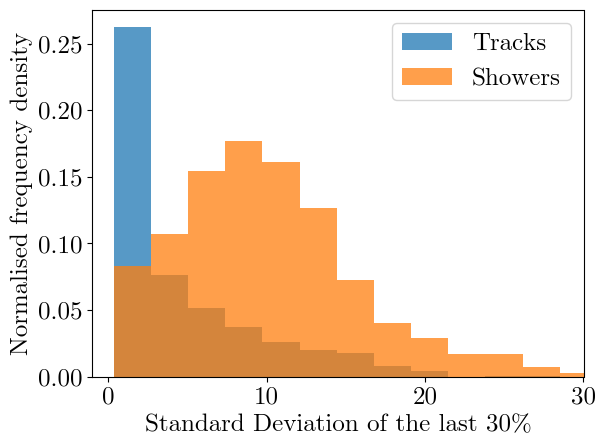

In [16]:
n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
# plt.title("Using standard deviation in residuals to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Standard Deviation of the last 30%")
plt.xlim(-1, 30)

plt.legend()
plt.tight_layout()
plt.savefig('sd.png', dpi=500)
plt.show()

In [14]:
random_numbers

array([3589, 3586, 2160, 4361, 4608, 5065, 9137, 3511, 1242, 8215,  222,
        407, 7199,  257, 5498, 8307, 4740, 2469, 6673, 1756, 1015, 4993,
       2727, 1102, 8543, 8743, 2305, 7795, 8080,  730, 5027,  322, 6522,
       1855, 5056, 2680, 4663, 4810, 6969, 8574, 6731, 7212, 5989, 3408,
       1341, 5920, 6607,  663,  314, 7487, 4888,  297, 7584, 1386, 9168,
       3552, 3914, 6333, 4314, 2014, 8055, 2014, 1570, 4566,  211, 1541,
       5809, 2603, 4375, 7343, 5887, 5645, 5061, 7534, 8265, 7309, 2544,
       6991, 6172, 6740, 2066, 3339, 5084, 1896, 8949, 2611,  670, 6119,
       7098, 1499, 7766, 1060, 9236, 9301, 7143, 3404, 3691, 4540, 6222,
       2532, 5035,   75, 8004, 1816, 8255, 5405, 5645, 8771, 1142, 4896,
       7975, 3921, 9019, 6176, 3872, 7690,  722, 3416, 7538, 7521, 8233,
       3674,  343,  160, 6021, 5984, 4724, 8709,   49, 6207, 2544, 5641,
       2130, 1669, 7422, 3714,  346, 8841, 3729, 2575, 1705, 8653, 6163,
       7481, 7073,  590, 9072, 4951, 5484, 7118, 37

In [15]:
var_se(1445)

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([13.22424698,  0.12269371,  3.58182073,  0.10811345,  0.39528617]),
 array([ 11., 211.,  22., 211., 211.]))